# Hamiltonian Monte Carlo with leapfrog

* 黒木玄
* 2021-12-06, 2022-09-03

Scalar version: https://github.com/genkuroki/public/blob/main/0018/HMC%20leapfrog.ipynb

2022-09-03: カーネルをJulia v1.8.0に変更して, ConcreteStructs.jl と Parameters.jl への依存を無くした.

In [1]:
# Sample code of Hamiltonian Monte Carlo with leapfrog

module My

using LinearAlgebra: dot
using ForwardDiff: gradient
using Random: default_rng, randn!
using StaticArrays: SVector, MVector

# Type of Leapfrog Problem
struct LFProblem{dim, F1, F2, F3, T, I}
    ϕ::F1
    H::F2
    F::F3
    dt::T
    nsteps::I
end

"""
    LFProblem(dim, ϕ, H, F, dt, nsteps)

Assume that `ϕ(x, param)` is a potential function of a `dim`-dimensional vector `x` and a parameter `param`, `H(x, v, param)` and `F(x, param)` the Hamiltonian and force functions corresponding to `ϕ`, `dt` a step of discretized time, and `nsteps` the number of steps.  Then it returns the Problem object of solving the Hamiltonian equation with leapfrog method.
"""
function LFProblem(dim, ϕ, H, F, dt, nsteps)
    F1, F2, F3, T, I = typeof(ϕ), typeof(H), typeof(F), typeof(dt), typeof(nsteps)
    LFProblem{dim, F1, F2, F3, T, I}(ϕ, H, F, dt, nsteps)
end

"""
    LFProblem(dim, ϕ; dt = 1.0, nsteps = 40)

Assume that `ϕ(x, param)` is a potential function of a `dim`-dimensional vector `x` and a parameter `param`.  Then it defines the Hamiltonian function `H(x, v, param)` and the force function `F(x, param)` corresponding to `ϕ` and returns `LFProblem(dim, ϕ, H, F, dt, nsteps)`.
"""
function LFProblem(dim, ϕ; dt = 1.0, nsteps = 40)
    H(x, v, param) = dot(v, v)/2 + ϕ(x, param)
    F(x, param) = -gradient(x -> ϕ(x, param), x)
    LFProblem(dim, ϕ, H, F, dt, nsteps)
end

"""
    LFProblem(dim, ϕ, ∇ϕ; dt = 1.0, nsteps = 40)

Assume that `ϕ(x, param)` is a potential function of a `dim`-dimensional vector `x` and a parameter `param` and `∇ϕ` its gradient with respect to `x`.  Then it deifnes the Hamiltonian function `H(x, v, param)` and the force function `F(x, param)` corresponding to `ϕ` and `∇ϕ` and returns `LFProblem(dim, ϕ, H, F, dt, nsteps)`.
"""
function LFProblem(dim, ϕ, ∇ϕ; dt = 1.0, nsteps = 40)
    H(x, v, param) = dot(v, v)/2 + ϕ(x, param)
    F(x, param) = -∇ϕ(x, param)
    LFProblem(dim, ϕ, H, F, dt, nsteps)
end

"""
    solve(lf::LFProblem, x, v, param)

numerically solve the Hamilton's equation of motion given by `lf` with leapfrog method, where (`x`, `v`) is the initial value and `param` is the parameter of the potential function `lf.ϕ`.
"""
function solve(lf::LFProblem, x, v, param)
    (; F, dt, nsteps) = lf
    v = v + F(x, param)*dt/2
    x = x + v*dt
    for _ in 2:nsteps
        v = v + F(x, param)*dt
        x = x + v*dt
    end
    v = v + F(x, param)*dt/2
    x, v
end

@inline function _update!(lf::LFProblem{dim}, x, vtmp, param, rng) where dim
    (; H) = lf
    v = SVector{dim}(randn!(rng, vtmp))
    xnew, vnew = solve(lf, x, v, param)
    dH = H(xnew, vnew, param) - H(x, v, param)
    rand(rng) ≤ exp(-dH) ? xnew : x
end

"""
    HMC(lf::LFProblem{dim}, param = nothing;
        niters = 10^5, thin = 1, nwarmups = 0, rng = default_rng(),
        init = SVector{dim}(randn(rng, dim))) where dim

generates the sample of the distribution given by the probability density function proportioal to exp(-`lf.ϕ(x, param)`) by Hamiltonian Monte Carlo method.
"""
function HMC(lf::LFProblem{dim}, param = nothing;
        niters = 10^5, thin = 1, nwarmups = 0, rng = default_rng(),
        init = SVector{dim}(randn(rng, dim))) where dim
    vtmp = MVector{dim}(zeros(eltype(init), dim))
    x = init
    for _ in 1:nwarmups
        x = _update!(lf, x, vtmp, param, rng)
    end
    sample = Vector{typeof(init)}(undef, niters)
    for i in 1:niters
        for _ in 1:thin
            x = _update!(lf, x, vtmp, param, rng)
        end
        @inbounds sample[i] = x
    end
    sample
end

end

Main.My

In [2]:
?My.LFProblem

```
LFProblem(dim, ϕ, H, F, dt, nsteps)
```

Assume that `ϕ(x, param)` is a potential function of a `dim`-dimensional vector `x` and a parameter `param`, `H(x, v, param)` and `F(x, param)` the Hamiltonian and force functions corresponding to `ϕ`, `dt` a step of discretized time, and `nsteps` the number of steps.  Then it returns the Problem object of solving the Hamiltonian equation with leapfrog method.

---

```
LFProblem(dim, ϕ; dt = 1.0, nsteps = 40)
```

Assume that `ϕ(x, param)` is a potential function of a `dim`-dimensional vector `x` and a parameter `param`.  Then it defines the Hamiltonian function `H(x, v, param)` and the force function `F(x, param)` corresponding to `ϕ` and returns `LFProblem(dim, ϕ, H, F, dt, nsteps)`.

---

```
LFProblem(dim, ϕ, ∇ϕ; dt = 1.0, nsteps = 40)
```

Assume that `ϕ(x, param)` is a potential function of a `dim`-dimensional vector `x` and a parameter `param` and `∇ϕ` its gradient with respect to `x`.  Then it deifnes the Hamiltonian function `H(x, v, param)` and the force function `F(x, param)` corresponding to `ϕ` and `∇ϕ` and returns `LFProblem(dim, ϕ, H, F, dt, nsteps)`.


In [3]:
?My.solve

```
solve(lf::LFProblem, x, v, param)
```

numerically solve the Hamilton's equation of motion given by `lf` with leapfrog method, where (`x`, `v`) is the initial value and `param` is the parameter of the potential function `lf.ϕ`.


In [4]:
?My.HMC

```
HMC(lf::LFProblem{dim}, param = nothing;
    niters = 10^5, thin = 1, nwarmups = 0, rng = default_rng(),
    init = SVector{dim}(randn(rng, dim))) where dim
```

generates the sample of the distribution given by the probability density function proportioal to exp(-`lf.ϕ(x, param)`) by Hamiltonian Monte Carlo method.


In [5]:
using Plots
using BenchmarkTools
using StaticArrays
using LinearAlgebra
using KernelDensity
using Statistics
using QuadGK
using Distributions
using Symbolics

## 2-dimensional normal distribution

In [6]:
A = @SMatrix [
     1  1/2
    1/2  1
]
param = (; A = A)
ϕ(x, param) = dot(x, param.A, x)/2
lf = My.LFProblem(2, ϕ)

Main.My.LFProblem{2, typeof(ϕ), Main.My.var"#H#3"{typeof(ϕ)}, Main.My.var"#F#4"{typeof(ϕ)}, Float64, Int64}(ϕ, Main.My.var"#H#3"{typeof(ϕ)}(ϕ), Main.My.var"#F#4"{typeof(ϕ)}(ϕ), 1.0, 40)

In [7]:
@time sample = My.HMC(lf, param)
@time sample = My.HMC(lf, param)
@time sample = My.HMC(lf, param);

  0.967557 seconds (2.27 M allocations: 126.243 MiB, 4.24% gc time, 94.16% compilation time)
  0.056512 seconds (4 allocations: 1.526 MiB)
  0.057569 seconds (4 allocations: 1.526 MiB)


In [8]:
@btime My.HMC($lf, $param);

  52.394 ms (4 allocations: 1.53 MiB)


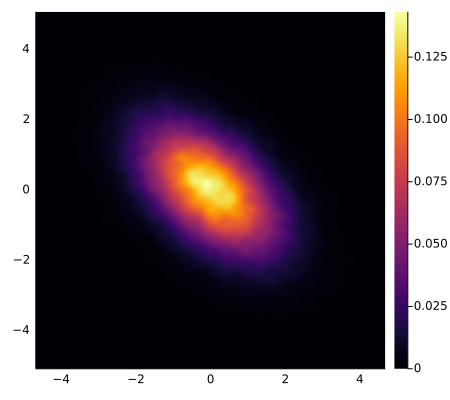

In [9]:
X, Y = first.(sample), last.(sample)
d = InterpKDE(kde((X, Y)))
x, y = range(extrema(X)...; length=201), range(extrema(Y)...; length=201)
heatmap(x, y, (x, y) -> pdf(d, x, y); size=(450, 400), right_margin=3Plots.mm)

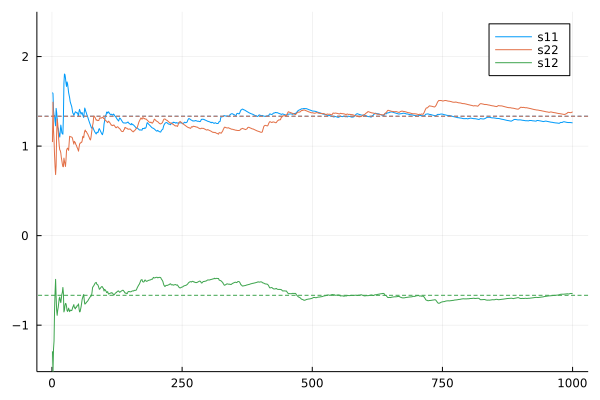

In [10]:
f(n) = mean(x -> x*x', @view sample[1:n])

n = 1:1000
S = f.(n)
S11 = (S -> S[1,1]).(S)
S22 = (S -> S[2,2]).(S)
S12 = (S -> S[1,2]).(S)

ymin = min(-1.5, minimum(S11), minimum(S22), minimum(S12))
ymax = max(2.5, maximum(S11), maximum(S22), maximum(S12))

plot(ylim = (ymin, ymax))
plot!(S11; label="s11", c=1)
hline!([inv(A)[1,1]]; label="", c=1, ls=:dash)
plot!(S22; label="s22", c=2)
hline!([inv(A)[2,2]]; label="", c=2, ls=:dash)
plot!(S12; label="s12", c=3)
hline!([inv(A)[1,2]]; label="", c=3, ls=:dash)

## φ(x) = a(x² - 1)²

  0.398456 seconds (1.07 M allocations: 61.863 MiB, 77.31% compilation time)
  0.082761 seconds (17 allocations: 1.526 MiB)
  0.087808 seconds (17 allocations: 1.526 MiB)
  0.086475 seconds (17 allocations: 1.526 MiB)
  0.085122 seconds (17 allocations: 1.526 MiB)
  0.085609 seconds (17 allocations: 1.526 MiB)


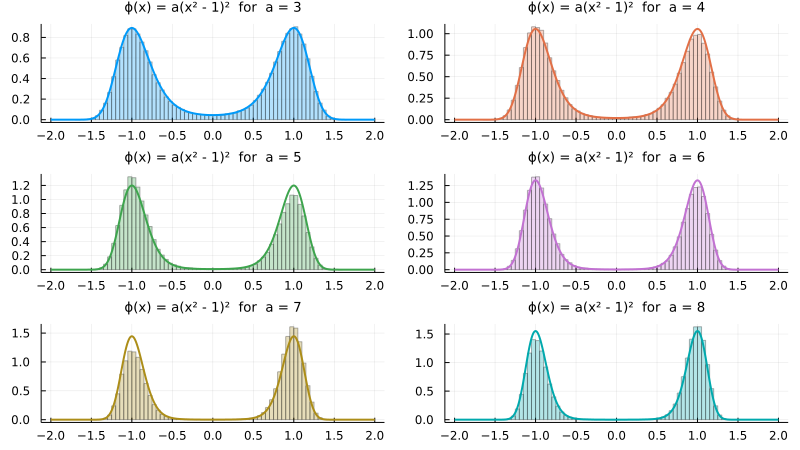

In [11]:
ϕ4(x, a) = a * (x[1]^2 - 1)^2
a = [3, 4, 5, 6, 7, 8]
XX = Vector{Float64}[]
ZZ = Float64[]
PP = []
for i in eachindex(a)
    Z = quadgk(x -> exp(-ϕ4((x,), a[i])), -Inf, Inf)[1]
    push!(ZZ, Z)
    lf = My.LFProblem(1, ϕ4; dt = 0.05, nsteps = 100)
    @time X = first.(My.HMC(lf, a[i]))
    flush(stdout)
    push!(XX, X)
    P = plot()
    histogram!(X; norm=true, alpha=0.3, label="HMC LF sample", bin=100, c=i)
    plot!(x -> exp(-ϕ4(x, a[i]))/Z, -2, 2; label="exp(-ϕ2(x))/Z", lw=2, c=i)
    plot!(; legend=false, xtick=-2:0.5:2)
    title!("ϕ(x) = a(x² - 1)²  for  a = $(a[i])", titlefontsize=9)
    push!(PP, P)
end
plot(PP...; size=(800, 450), layout=(3, 2))

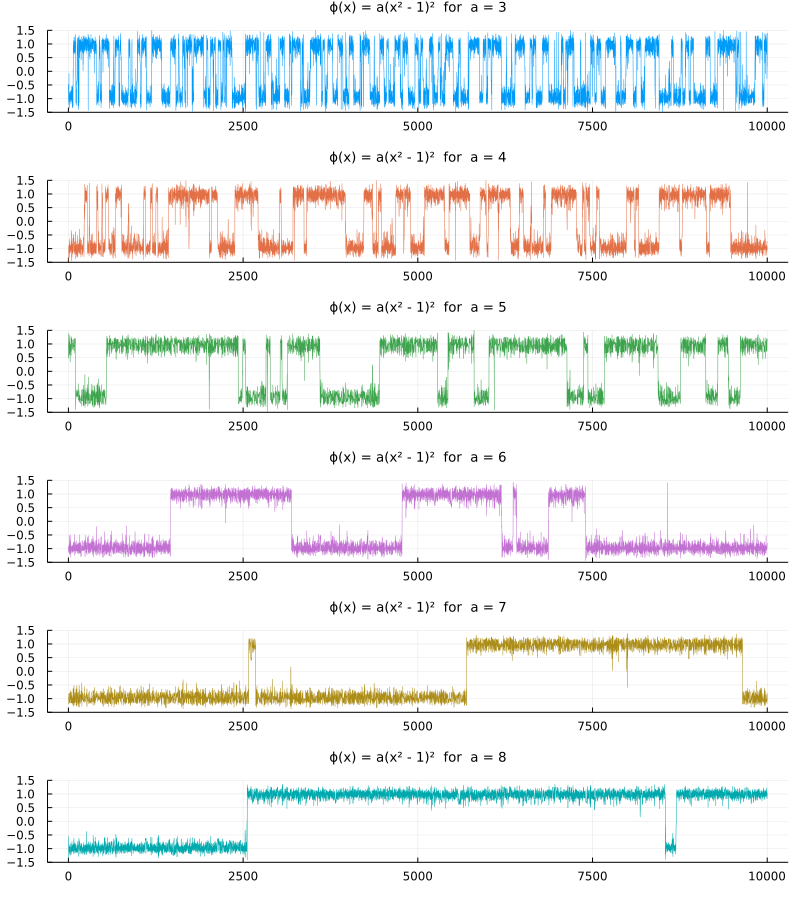

In [12]:
QQ = []
for i in eachindex(a)
    Q = plot(XX[i][1:10000]; ylim=(-1.5, 1.5), label="", c=i, lw=0.5)
    title!("ϕ(x) = a(x² - 1)²  for  a = $(a[i])", titlefontsize=9)
    push!(QQ, Q)
end
plot(QQ...; size=(800, 900), layout=(length(a), 1))

## Baysian inference for a sample of the standard normal distribution

In [13]:
n = 10
sample_normal = randn(n)
f(y, m, s) = (y - m)^2/(2s^2) + log(s)
negloglik(w, sample) = sum(y -> f(y, w[1], exp(w[2])), sample)
lf = My.LFProblem(2, negloglik; dt = 0.1, nsteps = 30)

Main.My.LFProblem{2, typeof(negloglik), Main.My.var"#H#3"{typeof(negloglik)}, Main.My.var"#F#4"{typeof(negloglik)}, Float64, Int64}(negloglik, Main.My.var"#H#3"{typeof(negloglik)}(negloglik), Main.My.var"#F#4"{typeof(negloglik)}(negloglik), 0.1, 30)

In [14]:
@time sample = My.HMC(lf, sample_normal; init = SVector(0.0, 0.0))
@time sample = My.HMC(lf, sample_normal; init = SVector(0.0, 0.0))
@time sample = My.HMC(lf, sample_normal; init = SVector(0.0, 0.0))

  0.928805 seconds (523.08 k allocations: 28.726 MiB, 2.16% gc time, 21.13% compilation time)
  0.738722 seconds (3 allocations: 1.526 MiB)
  0.732966 seconds (3 allocations: 1.526 MiB)


100000-element Vector{SVector{2, Float64}}:
 [0.2808963383016968, -0.0850139100101338]
 [0.10362935168951949, -0.12357443484880323]
 [0.33381587080106806, -0.3194664595540615]
 [0.08865059391238689, -0.18711549359242713]
 [0.4640628065183025, -0.24134729302029093]
 [0.044636008825220064, -0.14100619029803105]
 [0.3959908387069734, -0.2742529336583942]
 [0.13348146420984588, -0.34705068152376395]
 [0.14669602220119124, -0.32869017250054006]
 [0.4121643380676835, -0.1579548585694553]
 [0.4250665035491883, -0.30593240759744883]
 [0.04166611134427756, -0.2330193376509495]
 [0.47965330500629877, -0.10474723006036145]
 ⋮
 [-0.08764472165726266, 0.09113787329216483]
 [0.5987313387896349, 0.20965789447320693]
 [0.34081831941965435, 0.6281018061918996]
 [-0.18478463857491062, 0.6063828055588716]
 [1.0066149007384484, 0.5467211516531318]
 [0.03564943258579456, 0.23211738965114237]
 [0.519419263816568, 0.22204375458922126]
 [-0.1105239217011224, 0.3291869366389478]
 [0.5551195562503037, 0.3350043

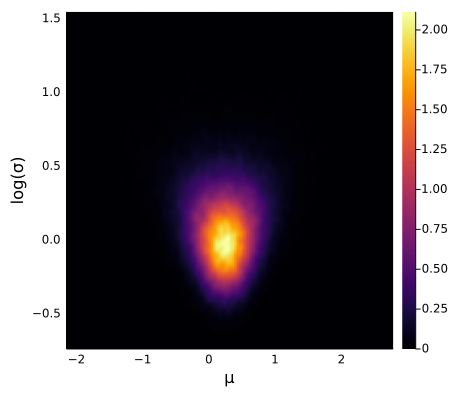

In [15]:
m, logs = first.(sample), last.(sample)
d = InterpKDE(kde((m, logs)))
x, y = range(extrema(m)...; length=201), range(extrema(logs)...; length=201)
heatmap(x, y, (x, y) -> pdf(d, x, y); size=(450, 400), xlabel="μ", ylabel="log(σ)")

## Symbolics.jl example

In [16]:
dim = 2
@variables a[1:dim, 1:dim], x[1:dim]
aa, xx = collect.((a, x))

(Num[a[1, 1] a[1, 2]; a[2, 1] a[2, 2]], Num[x[1], x[2]])

In [17]:
phi_sym = dot(xx, aa, xx)/2 |> expand |> simplify

((1//2)*a[1, 2] + (1//2)*a[2, 1])*x[1]*x[2] + (1//2)*(x[1]^2)*a[1, 1] + (1//2)*(x[2]^2)*a[2, 2]

In [18]:
dphi_sym = Symbolics.gradient(phi_sym, xx)

2-element Vector{Num}:
 ((1//2)*a[1, 2] + (1//2)*a[2, 1])*x[2] + x[1]*a[1, 1]
 ((1//2)*a[1, 2] + (1//2)*a[2, 1])*x[1] + x[2]*a[2, 2]

In [19]:
phi_rgf = build_function(phi_sym, xx, aa; expression = Val(false))
dphi_rgf = build_function(dphi_sym, xx, aa; expression = Val(false))[1]
lf = My.LFProblem(dim, phi_rgf, dphi_rgf);

In [20]:
param = A = @SMatrix [
     1  1/2
    1/2  1
]

2×2 SMatrix{2, 2, Float64, 4} with indices SOneTo(2)×SOneTo(2):
 1.0  0.5
 0.5  1.0

In [21]:
@time sample = My.HMC(lf, param)
@time sample = My.HMC(lf, param)
@time sample = My.HMC(lf, param);

  0.174535 seconds (314.75 k allocations: 18.494 MiB, 84.32% compilation time)
  0.027935 seconds (4 allocations: 1.526 MiB)
  0.026462 seconds (4 allocations: 1.526 MiB)


In [22]:
@btime My.HMC($lf, $param);

  25.828 ms (4 allocations: 1.53 MiB)


自動微分を使うよりも計算が速くなっている.

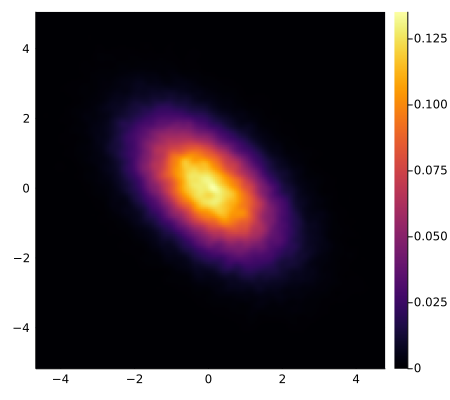

In [23]:
X, Y = first.(sample), last.(sample)
d = InterpKDE(kde((X, Y)))
x, y = range(extrema(X)...; length=201), range(extrema(Y)...; length=201)
heatmap(x, y, (x, y) -> pdf(d, x, y); size=(450, 400), right_margin=3Plots.mm)

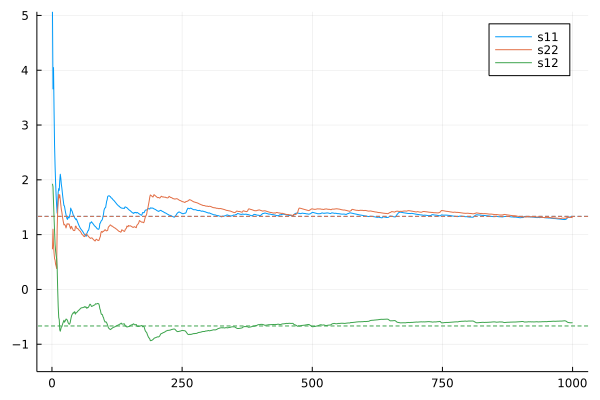

In [24]:
f(n) = mean(x -> x*x', @view sample[1:n])

n = 1:1000
S = f.(n)
S11 = (S -> S[1,1]).(S)
S22 = (S -> S[2,2]).(S)
S12 = (S -> S[1,2]).(S)

ymin = min(-1.5, minimum(S11), minimum(S22), minimum(S12))
ymax = max(2.5, maximum(S11), maximum(S22), maximum(S12))

plot(ylim = (ymin, ymax))
plot!(S11; label="s11", c=1)
hline!([inv(A)[1,1]]; label="", c=1, ls=:dash)
plot!(S22; label="s22", c=2)
hline!([inv(A)[2,2]]; label="", c=2, ls=:dash)
plot!(S12; label="s12", c=3)
hline!([inv(A)[1,2]]; label="", c=3, ls=:dash)